步骤 1: 加载和预处理数据
GoEmotions 数据集的标签需要重新映射为五个情感类别：非常负面、负面、中性、正面、非常正面。

首先，我们需要加载数据集并进行标签映射（情感从多种类别转换为五类）。同时，中文输入需要使用适合中文的预训练模型。

In [1]:

from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# 加载 GoEmotions 数据集
dataset = load_dataset("go_emotions")
print(dataset['train'].features)

# 五分类映射
five_class_mapping = {
    'anger': 0, 'disgust': 0, 'fear': 0, 'sadness': 0,
    'annoyance': 1, 'disappointment': 1,
    'neutral': 2,
    'approval': 3, 'joy': 3, 'love': 3, 'optimism': 3,
    'admiration': 4, 'excitement': 4, 'gratitude': 4, 'pride': 4, 'relief': 4
}

id2label = ['very negative', 'negative', 'neutral', 'positive', 'very positive']


# 你已经定义了 five_class_mapping 和 map_emotion 函数
def map_emotion(example):
    label_ids = example['labels']
    emotions = [dataset['train'].features['labels'].feature.names[i] for i in label_ids]
    
    # 将情感类别映射为五分类标签
    for emo in emotions:
        if emo in five_class_mapping:
            return {'five_class_label': five_class_mapping[emo]}
    return {'five_class_label': 2}  # 默认为 neutral

# 在训练集、验证集和测试集上应用映射函数
dataset['train'] = dataset['train'].map(map_emotion)
dataset['validation'] = dataset['validation'].map(map_emotion)
dataset['test'] = dataset['test'].map(map_emotion)



# def map_emotion(example):
#     label_ids = example['labels']
#     emotions = [dataset['train'].features['labels'].feature.names[i] for i in label_ids]
    
#     for emo in emotions:
#         if emo in five_class_mapping:
#             return {'five_class_label': five_class_mapping[emo]}
#     return {'five_class_label': 2}  # 默认为 neutral

# dataset['train'] = dataset['train'].map(map_emotion)






e:\demo\EmotionApp\backend\EmotionAppBackend\Algorithm\HuggingFace\hf\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Using the latest cached version of the dataset since go_emotions couldn't be found on the Hugging Face Hub
Found the latest cached dataset configuration 'simplified' at C:\Users\lyq\.cache\huggingface\datasets\go_emotions\simplified\0.0.0\add492243ff905527e67aeb8b80c082af02207c3 (last modified on Sat Apr  5 02:51:39 2025).


{'text': Value(dtype='string', id=None), 'labels': Sequence(feature=ClassLabel(names=['admiration', 'amusement', 'anger', 'annoyance', 'approval', 'caring', 'confusion', 'curiosity', 'desire', 'disappointment', 'disapproval', 'disgust', 'embarrassment', 'excitement', 'fear', 'gratitude', 'grief', 'joy', 'love', 'nervousness', 'optimism', 'pride', 'realization', 'relief', 'remorse', 'sadness', 'surprise', 'neutral'], id=None), length=-1, id=None), 'id': Value(dtype='string', id=None)}


In [2]:
# 选择训练集
# train_data = dataset['train']

步骤 2: 加载中文BERT模型
为了处理中文文本，使用 bert-base-chinese 作为预训练模型。加载并准备分词器和模型。

In [3]:
from transformers import Trainer, TrainingArguments
from torch.utils.data import DataLoader
from datasets import Dataset, DatasetDict

# 将数据集转换为训练所需的格式
def tokenize_function(examples):
    return tokenizer(examples['text'], padding="max_length", truncation=True, max_length=512)

# 初始化 BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-chinese')

# 对数据集进行分词
dataset = dataset.map(tokenize_function, batched=True)

# 创建训练集和验证集
train_dataset = dataset['train']
val_dataset = dataset['validation']

print(dataset)

# 定义 EmotionDataset 类
class EmotionDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# 提取训练数据和标签
train_encodings = tokenizer(train_dataset['text'], truncation=True, padding=True, max_length=512)
train_labels = train_dataset['five_class_label']

# 提取验证数据和标签
val_encodings = tokenizer(val_dataset['text'], truncation=True, padding=True, max_length=512)
val_labels = val_dataset['five_class_label']

# 创建训练数据集
train_data = EmotionDataset(train_encodings, train_labels)
val_data = EmotionDataset(val_encodings, val_labels)

DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id', 'five_class_label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id', 'five_class_label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id', 'five_class_label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 5427
    })
})


步骤 3: 设置训练参数和训练模型
使用 Trainer 进行模型训练。我们还可以设置 TensorBoard 或 matplotlib 来绘制训练趋势图。

In [ ]:
from transformers import Trainer, TrainingArguments
from torch.utils.tensorboard import SummaryWriter
import matplotlib.pyplot as plt


# 使用 Trainer API 设置训练参数
training_args = TrainingArguments(
    output_dir='./results',          # 输出目录
    num_train_epochs=3,              # 训练轮次
    per_device_train_batch_size=16,  # 每个设备上的批次大小
    per_device_eval_batch_size=64,   # 验证时每个设备上的批次大小
    warmup_steps=500,                # 热身步数
    weight_decay=0.01,               # 权重衰减
    logging_dir='./logs',            # 日志目录
    logging_steps=10,
    evaluation_strategy="epoch",     # 每轮评估一次
)

# 使用 BERT 模型
model = BertForSequenceClassification.from_pretrained('bert-base-chinese', num_labels=5)

# 使用 Trainer 进行训练
trainer = Trainer(
    model=model,                         # 模型
    args=training_args,                  # 训练参数
    train_dataset=train_data,            # 训练数据集
    eval_dataset=val_data,               # 验证数据集
    tokenizer=tokenizer,                 # tokenizer
)

# 开始训练
trainer.train()

# 保存模型
model.save_pretrained('./emotion_model')
tokenizer.save_pretrained('./emotion_model')


e:\demo\EmotionApp\backend\EmotionAppBackend\Algorithm\HuggingFace\hf\Lib\site-packages\transformers\training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\lyq\AppData\Local\Temp\ipykernel_8156\2353167339.py:23: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss
1,1.140800,0.996684
2,0.918500,0.958338
3,0.801000,0.931388


('./emotion_model\\tokenizer_config.json',
 './emotion_model\\special_tokens_map.json',
 './emotion_model\\vocab.txt',
 './emotion_model\\added_tokens.json')

步骤 4: 绘制训练趋势图
使用 matplotlib 或 TensorBoard 绘制训练损失趋势图。以下是用 matplotlib 绘制的示例：

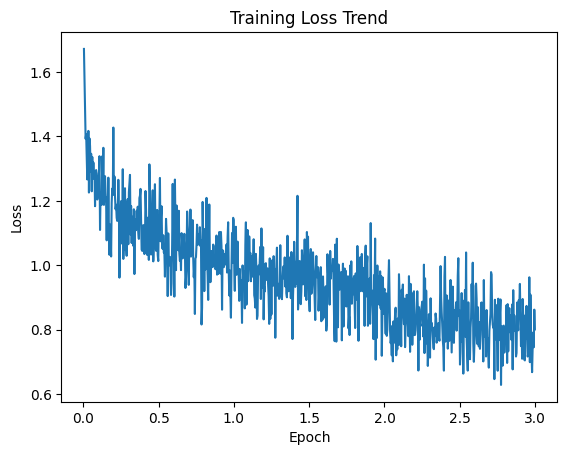

In [5]:
# 获取训练损失历史
losses = trainer.state.log_history
epochs = [x['epoch'] for x in losses if 'loss' in x]
train_loss = [x['loss'] for x in losses if 'loss' in x]

# 绘制训练损失图
plt.plot(epochs, train_loss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Trend')
plt.show()


步骤 5: 情感强度分析
情感强度分析可以通过模型的输出（即 logits）进行。我们可以使用 softmax 将 logits 转化为概率，并通过最大概率判断情感强度。

In [1]:
import torch
from torch.nn.functional import softmax

# 假设输入为单个文本样本
inputs = tokenizer("I am so happy today!")

# 获取模型的输出 logits
outputs = model(**inputs)
logits = outputs.logits

# 计算情感概率
probabilities = softmax(logits, dim=-1)

# 获取情感强度（最大概率值）
emotion_intensity = torch.max(probabilities, dim=1)
print(f"情感强度: {emotion_intensity.values.item()}")  # 显示情感强度值


NameError: name 'tokenizer' is not defined

步骤 6: 模型评估和准确度计算
最后，可以使用 trainer.evaluate() 来评估模型并计算准确度：

In [7]:
eval_results = trainer.evaluate()
accuracy = eval_results['eval_accuracy']
print(f"Validation Accuracy: {accuracy:.2f}")

KeyError: 'eval_accuracy'

In [10]:
from sklearn.metrics import accuracy_score
import numpy as np

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    acc = accuracy_score(labels, preds)
    return {'eval_accuracy': acc}


from transformers import Trainer

trainer = Trainer(
    model=model,  # 加载好的模型
    args=training_args,  # 原来的训练参数
    train_dataset=train_data,            # 训练数据集
    eval_dataset=val_data, 
    tokenizer=tokenizer,
    compute_metrics=compute_metrics  # 加上这行即可
)
eval_results = trainer.evaluate()
accuracy = eval_results['eval_accuracy']
print(f"Validation Accuracy: {accuracy:.2f}")


C:\Users\lyq\AppData\Local\Temp\ipykernel_8156\2706415979.py:13: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Validation Accuracy: 0.67
